# PyOD - 异常处理框架

## PyOD 常见模型总结

### 1.Angle-based Outlier Detector
#### 1. API
`class pyod.models.abod.ABOD(contamination = 0.1, n_neighbors = 5, method = 'fast`
#### 2. 原理简介
原理：我们认为如果一个点是不是异常点，则它到其他点的角度应该是在0-360度内均匀分布，即它到其他点的角度方差较大，有较大的角度变化。而如果一个点到其他点的角度在一个相似的方向，则我们认为这个点是异常点。下图可以较为直观的说明原理：
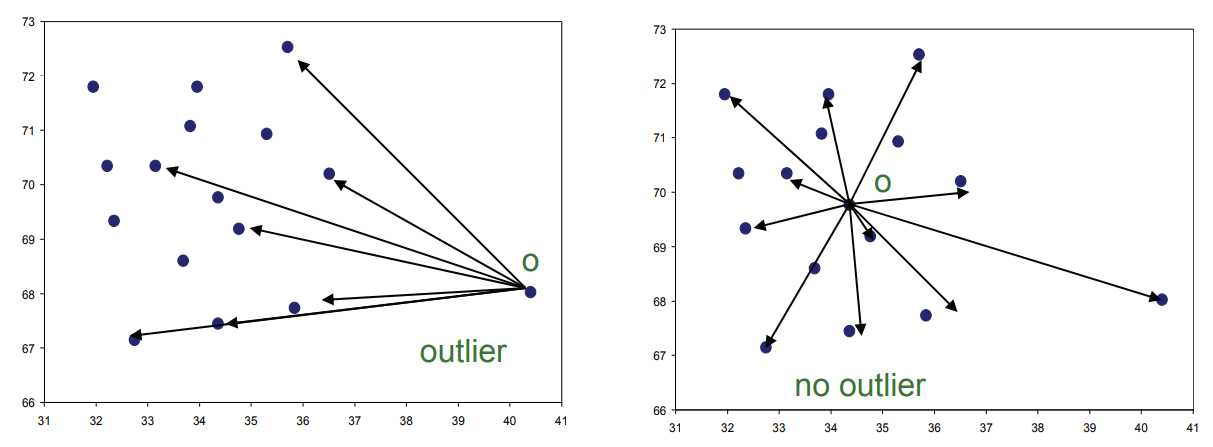
因此，我们可以将异常点的判断标准总结为，对于当前点`o`
- 如果大多数其他点相对于当前点前位于相似的方向（角度变化较小，方差较小），则当前对象为异常值
- 如果许多其他店相对于当前点位于不同的方向（角度变化较大，方差较大），则当前对象不是异常值

#### 3. 如何计算角度
通过计算夹角的余弦值来计算角度：在ABOD的论文中是如下定义的
> The angle-based outlier factor $ABOF(\vec{A})$ is the variance over the angles between the difference vectors of $\vec{A}$ to all pairs of points in $D$ weighted by the distance of the points: $$ABOF(\vec{A}) = VAR_{\vec{B},\vec{C}\in D}(\frac{(\vec{AB},\vec{AC})}{||\vec{AB}||^2||\vec{AC}||^2})$$

#### 4. 常见应用场景
高维数据，例如这篇论文[^1]详细介绍了ABOD在高维数据下的运用。其中提到了ABOD的几例变式
1. ABOD
2. Speed up by Approximation (FastABOD)
3. Approximation as Filter-Refinement Approach (LB-ABOD)
4. Generalization for Arbitrary Data Types (Kernel-based ABOF)

#### 5. 参考文献
[^1]:Angle-Based Outlier Detection in High-dimensional Data

### 2.Auto-encoder
#### 1. API
`class pyod.models.auto_encoder.AutoEncoder(hidden_neurons=None, hidden_activation='relu', output_activation='sigmoid', loss=<function mean_squared_error>, optimizer='adam', epochs=100, batch_size=32, dropout_rate=0.2, l2_regularizer=0.1, validation_size=0.1, preprocessing=True, verbose=1, random_state=None, contamination=0.1)[source]`
#### 2. 原理简介
1. 自动编码器可以作为一种无监督学习手段来检测异常。
2. 自动编码器的过程可以概述为：原始数据->Encoder->隐向量->Decoder->重构数据
  - 原始数据经过Encoder会被降维成一个维度较低的隐向量Latent Vector，在降维的过程中势必会丢掉原始数据中的一些内容
  - Latent Vector经过Decoder会重构生成一个和原始数据相同维度的数据，而因为在Encoder降维的过程中势必会丢掉一些**不重要的数据**，所以Decoder重构得到的结果中并没有这些所谓的**不重要的数据**
  - 我们认为这些不重要的数据为异常。这样的认知是基于：在异常检测任务中，正常数据和异常数据在数量上有较强的不平衡性。即：正常数据较多，异常数据较少（这也是异常检测和传统二分类问题的显著差异之一）。所以我们在降维的过程中，实际上是扔掉这些异常数据，而在Decoder重构的过程中，也很难重构出这些异常的数据。
  - 综上所述，我们只要比较重构数据和原始数据的差异，差异的地方我们就可以认为是异常。
3. 损失函数：我们希望Encoder和Decoder组成的自动编码器可以最大程度上还原原始数据的内容，所以损失函数定义为Reconstruction Loss（重构误差）
$$
Reconstruction\ Loss = min(input\_data, reconstruction\_data)^2
$$
4. 缺点：AE常常会有overfitting的问题。
  - 为了改善这一个问题，提出了变分自动编码器$VAE$和$\beta-VAE$
  - 以及其他常见的编码器：降噪自动编码器DAE，堆叠自动编码器SAE
5. 应用：自动编码器常常应用于深度生成领域。而在深度生成领域较为火热的模型GAN在Anomaly Detection领域也有较为不错的表现
6. 推荐阅读
  - VAE模型在周期性异常检测中的应用: Xu, Haowen, et al. "Unsupervised anomaly detection via variational auto-encoder for seasonal kpis in web applications." Proceedings of the 2018 World Wide Web Conference. 2018. 这篇文章提出了Donut异常检测模型，显著提高了异常检测的准确率。**（实际上Donut模型在2019年和2020年多次被用来和其他模型对比，且异常检测效果落后于2019年和2020年的诸多模型。但既然有如此之多的模型选择和Donut进行对比，也可以说明这篇论文的有很高的阅读价值）**

### 3.Isolation Forest
#### 1.API
`classpyod.models.iforest.IForest(n_estimators=100, max_samples='auto', contamination=0.1, max_features=1.0, bootstrap=False, n_jobs=1, behaviour='old', random_state=None, verbose=0)`
#### 2.原理总结
1. 常规的异常检测都是通过识别正常的观测值，筛除正常的观测值来留下异常点，Isolation Forest是直接去寻找异常点而非筛除正常点
2. Similarly to [[Random Forest]], it is built on an [[Ensemble Learning]] of [[Decision Tree]]
3. Isolation Forest最主要的问题是，在下文提到的Random Split算法中，只能进行与轴的平行分割。（见下文的分割图，分割线只能垂直分割或者水平分割，而不能斜向分割）

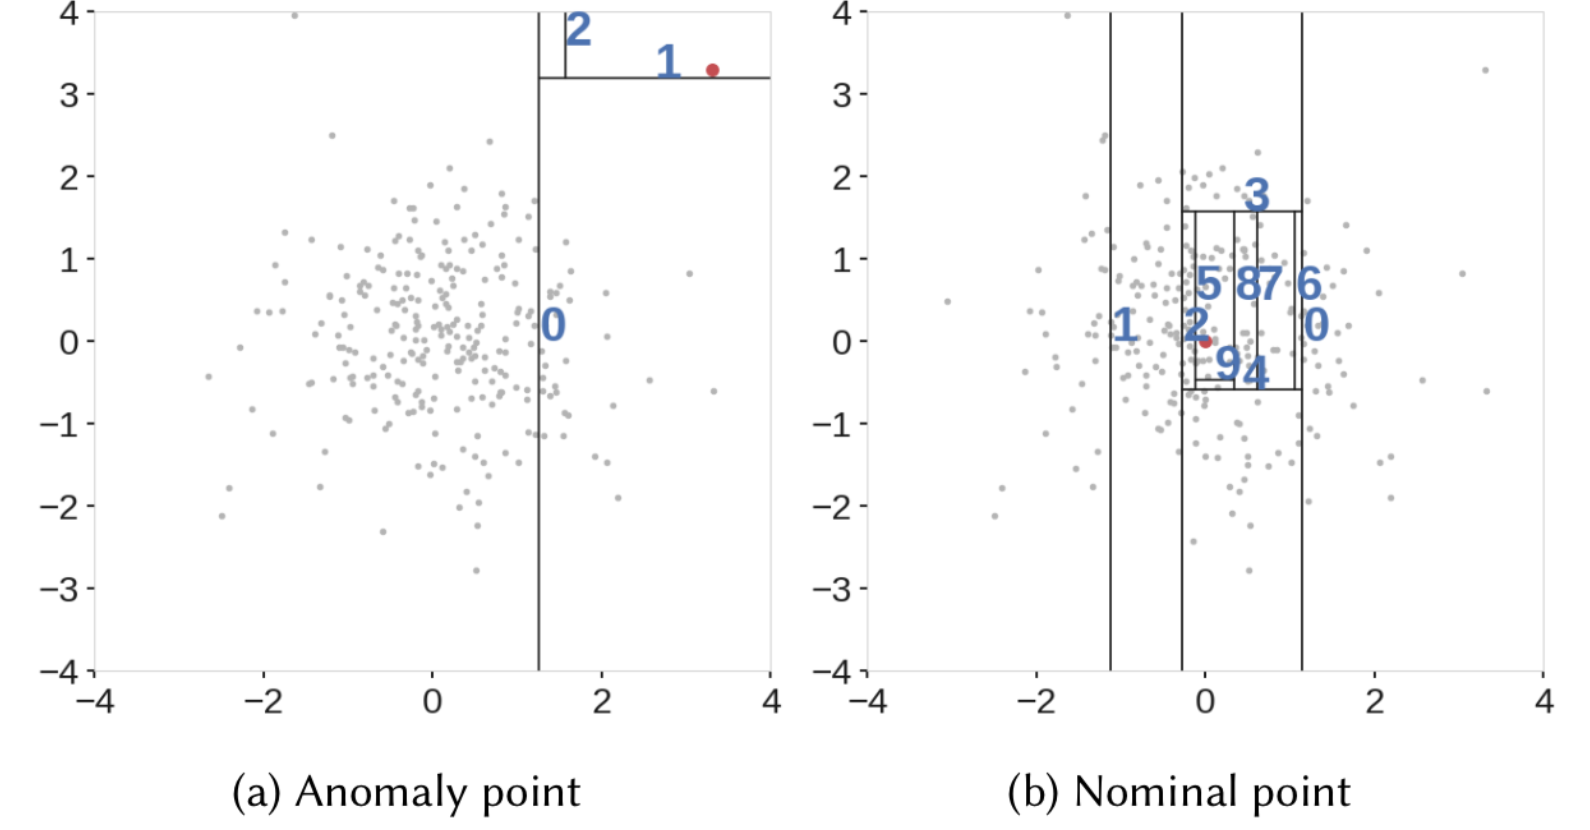

  - 解释：以上图为例，我们认为Point 1为一个异常点，显然如果我们Random Split，很容易就将Normal Point和Point 1分割开。Point 1的离群特性让它在Random Split中极易被分割出去。而Normal Point因为聚集在一起，所以如果我们想要得到某个Isolation Normal Point，我们需要和图(b)一样，不断，多次分割来得到结果。这就导致Root到Leaf Node的距离较长

4. Anomaly Score - 基于以上理论推导，可以知道Anomaly Point的Path Length较短，Normal Point的Path Length较长。所以可以定义Anomaly Score公式为：$$s(x,n) = 2^{-E(h(x)/c(n}$$
  - h(x) = the path length of observation x
  - c(n) = the average path length of unsuccessful serach in a BST
  - n = number of external nodes

#### 3.改善算法 - Extended Isolation Forest
1. Isolation Forest最主要的缺点是：Random Split算法只能水平|垂直切割特征。
2. 改善：Extended Isolation Forest不再遵循Isolation Forest的算法步骤
  - EIF算法选择 => 随机斜率和随机截距 => 从而进行不平行于轴的切割
切割效果如下：

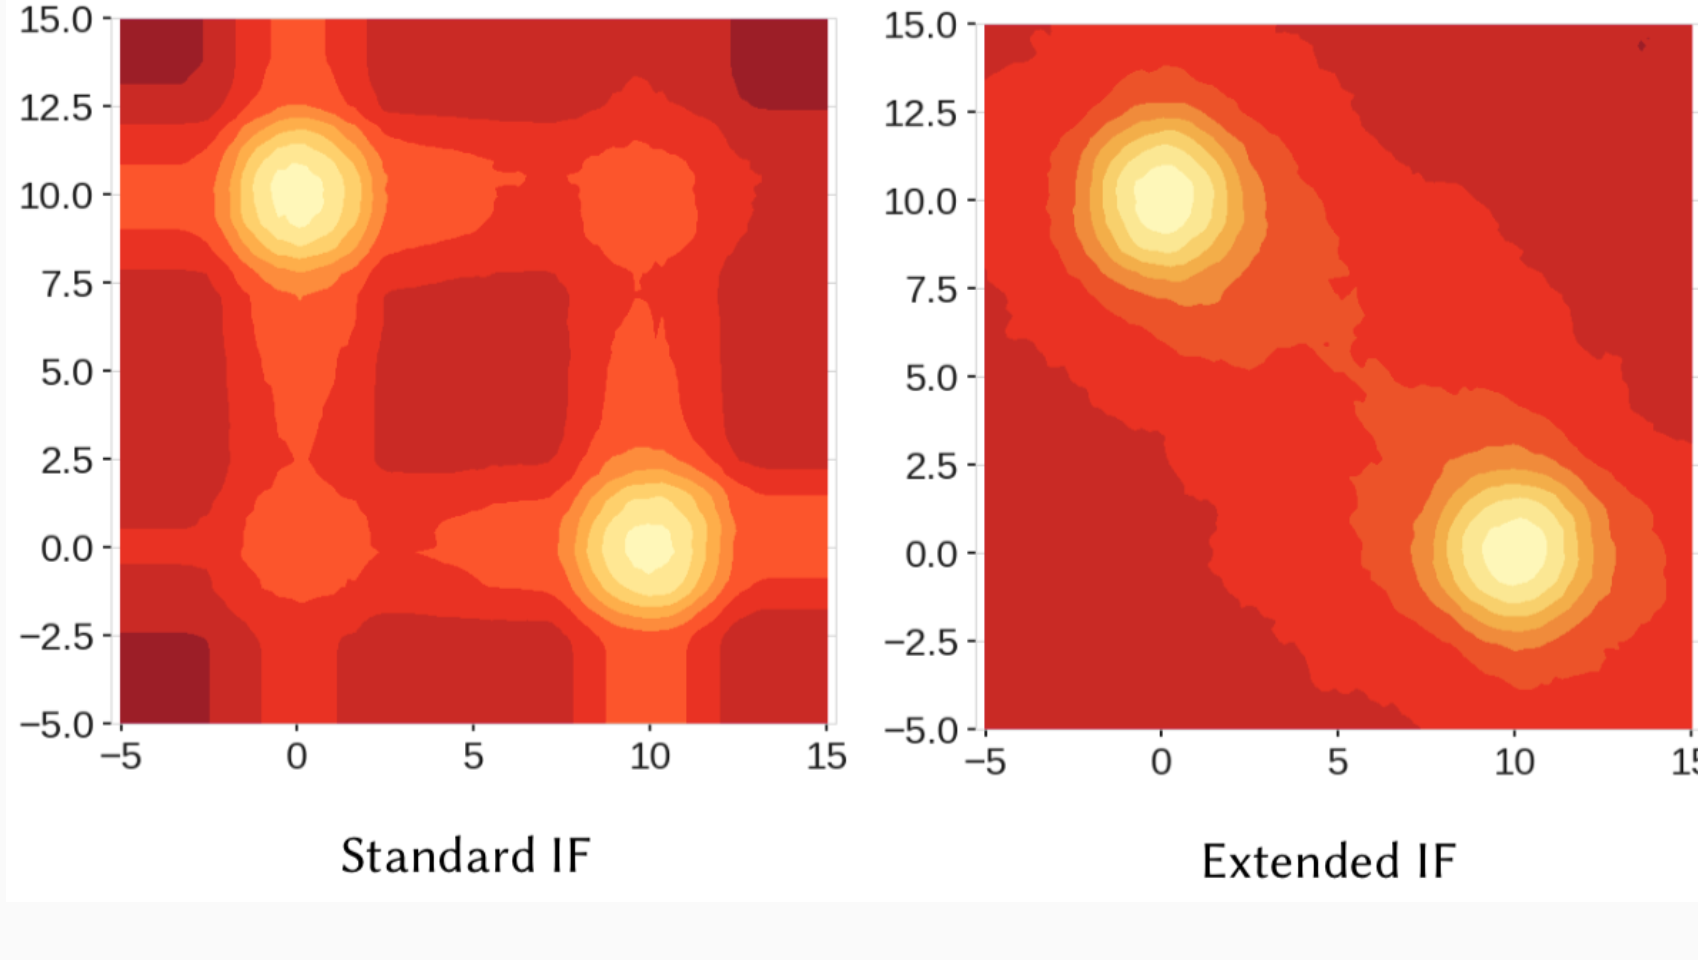

#### 4.参考文献
https://towardsdatascience.com/outlier-detection-with-isolation-forest-3d190448d45e↩︎

https://towardsdatascience.com/outlier-detection-with-extended-isolation-forest-1e248a3fe97b↩︎

### 4.PCA 
#### 1.API
`classpyod.models.pca.PCA(n_components=None, n_selected_components=None, contamination=0.1, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None, weighted=True, standardization=True)`
#### 2.主要原理
- 主成分分析(PCA)算法的思路非常简单，但从效果和性能上来讲可能并不优于前文提到的自动编码器算法。
- PCA的主要想法是，根据Input输入的$n_d$个Features，构建$n_e$个新的独立特征。并希望新的独立特征可以尽可能地接近Input Space。**换句话说，PCA正在寻找Input Space的最佳线性子空间，该子空间由$n_e$个新的正交独立特征构成，子空间评判标准是让Input Space在该子空间上的投影误差尽可能地笑。如下图所示：
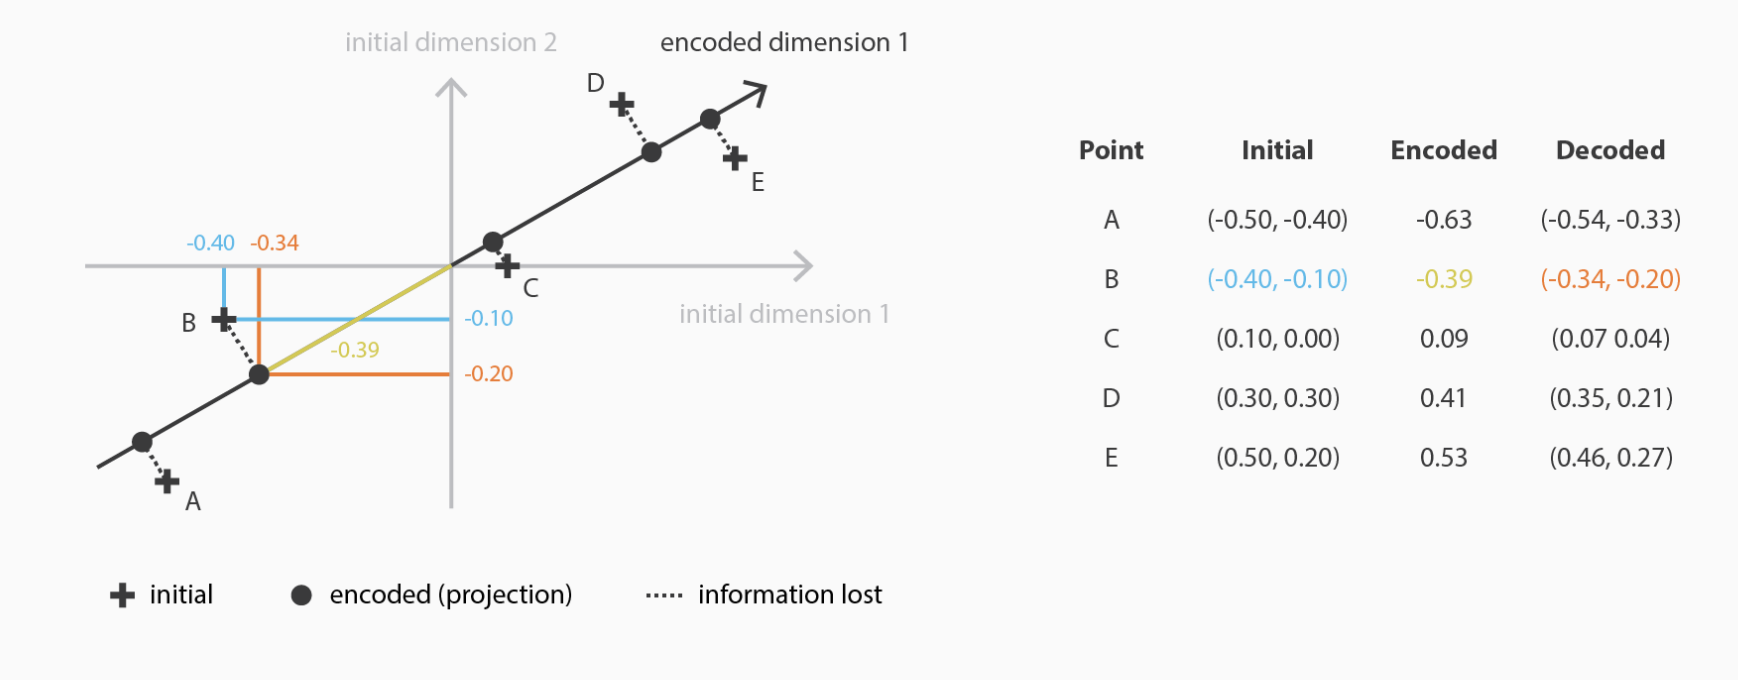

### 5.VAE
#### 1.API
`classpyod.models.vae.VAE(encoder_neurons=None, decoder_neurons=None, latent_dim=2, hidden_activation='relu', output_activation='sigmoid', loss=<function mean_squared_error>, optimizer='adam', epochs=100, batch_size=32, dropout_rate=0.2, l2_regularizer=0.1, validation_size=0.1, preprocessing=True, verbose=1, random_state=None, contamination=0.1, gamma=1.0, capacity=0.0)`
#### 2.主要原理
VAE的提出肯定是为了解决AE在一些问题上的局限性
##### 2.1 Limitations of Autoencoders For Content Generation
Autoencoders和Content Generation之间有什么联系呢？

1. 我们一旦得到训练后的Autoencoders，我们实际上就得到了训练好的Encoder和Decoder

2. 如果Latent Space足够有规律[ The regularity of the latent space ] ，每个维度的意义比较明朗，我们就可以Latent Space中随机取一个点，进行Decode就可以得到一个新的内容

3. 此时，Decoder的作用就会像一个Content Generator

我们发现Auto-encoder的Latent Space的规律性[ The regulartiy of the latent space ]是一个难点。它取决于[ Input Distribution, The dimension of The Latent Space, The Architecture of The Encoder ]

实际上，我们可以让Encoder将每个Input编码成为一个数轴上的点，比如如果输入是（39岁，男性，医生）编码成0，（25岁，女性，产品经理）编码成1，（55岁，男性，退休）编码成2。这样我们将3D的Input降维成了1D的Latent Space，而且可以No Reconstruction Error在Decoder还原出来。

- 实际上，我们用这种将input和latent space一一对应的方式，可以将所有输入都转换为 1D Latent Space。「但这种情况显然是一种严重的Overfitting，也是Auto-encoder的局限性。」
- 这样意味着Latent Space的一些Point经过Decoder会给出无意义的内容，例如如果我们提取Latent Vector，值为4，因为前面只出现过0，1，2，我们把4交付给Decoder他其实也不知道要生成什么东西，从而会给出一些无意义的内容
- 我们的理想情况是，我们可以进行适当的降维，例如降维到2D Latent Space，其中每个元素都有较为明确且规律的含义。比如[x,y]，可能对于AE来说，x就代表年龄和性别，y代表职业，这样我们将x的值调大一点，我们可能就会得到（66岁，男性，医生），显然这是一个全新的值，在这种情况下，因为Latent Space的规律性，我们才可以利用Decoder来生成一些我们倾向于生成的东西

所以，我们为了防止Auto-encoder的Overfitting情况（见上文），我们可以需要对其进行正则化Regularization

##### 2.2 Definition of Variational Auto-encoders

根据前文我们知道，为了让AE成为一个Content Generator，我们需要确保Latent Space要有一定的规律性。我们需要对其进行Regularization。

我们的做法是，并非将Input编码为一个Single Point，而是Encode为在Latent space上的一个Distribtuion => 这也是AE和VAE的不同，AE是确定性的，VAE是概率性的。

我们将Training过程修改如下

1. First, the input is encoded as distribution over the latent space => 将Input编码为在Latent Space上的Distribution
2. Second, a point from the latent space is sampled from that distribution => 从该Distribution中Sample A Point
3. Third, the sampled point is decoded and the reconstruction error can be computed => Decode并且计算Reconstruction Error
4. Finally, the reconstruction error is backpropagated through the network => 反向传播

在实践中，编码后的分布Encoded Distributions被选为Gaussian Distribution，这样Encoder实际上传递的是描述这个Gaussian Distribtuion的Mean和Variance

这里需要解释为什么我们要用概率分布Distribution而非确定的值，有如下几个原因
1. 它可以比较自然地表达Latent Space的正则化（Regularization）
2. Encode编码得到的Distribtuion会被强制要求接近Standard Normal/Gaussian Distribution
3. 我们以这种方式确保了Latent Space的局部正则化和全局正则化 => 局部正则化是由Variance控制，全局正则化是由Mean控制）

**VAE的损失函数如下：**

$$
loss = ||x-\hat{x}||^2 + KL[N(\mu,\sigma_x)||N(0,1)]
$$

- 第一项即Reconstruction Error
- 第二项倾向于让Encode返回的Distribution接近Standard Gaussian Distribution，从而让Latent Space正则化。两个分布之间的相似程度我们用KL散度来表示

**实际上，这里涉及一些较为复杂的数学推导，在这里并不进行详述，以下是一些学习VAE的参考资料：**

- [ Review ] Unsupervised anomaly detection via variational auto-encoder for seasonal KPIs in web applications https://blog.acolyer.org/2018/05/25/unsupervised-anomaly-detection-via-variational-auto-encoder-for-seasonal-kpis-in-web-applications/
- [ Review ] AIOps探索：基于VAE模型的周期性KPI异常检测方法——VAE异常检测
- [ VAE ] Understanding Variational Autoencoders VAE https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73
- [ VAE ] Variational autoencoders 1 - the basics https://hackmd.io/s/rJLgXVVrE#mjx-eqn-d
- [ SGVB ] SGVB Estimator https://blog.csdn.net/mch2869253130/article/details/106725342
- [ VAE ] 深度学习：变分自编码器 https://www.cnblogs.com/liuxiangyan/p/12594557.html
- [ VAE ] Variational Autoencoders Arxiv Insights https://www.youtube.com/watch?v=9zKuYvjFFS8
- [ VAE ] ML Lecture 18: Unsupervised Learning - Deep Generative Model (Part II) By Hung-yi Lee https://www.youtube.com/watch?v=8zomhgKrsmQ&t=1209s
- [ β-VAE ] Disentanglement with Variational Autoencoder: A Review https://towardsdatascience.com/disentanglement-with-variational-autoencoder-a-review-653a891b69bd
- [ β-VAE ] Vartional Inference of Disentangeled Latent Concepts From Unlabeled Observations https://arxiv.org/pdf/1711.00848.pdf
- [ VI EM GMM ] 神经网络与深度学习 nndl.github.io

### 6.模型总结分类
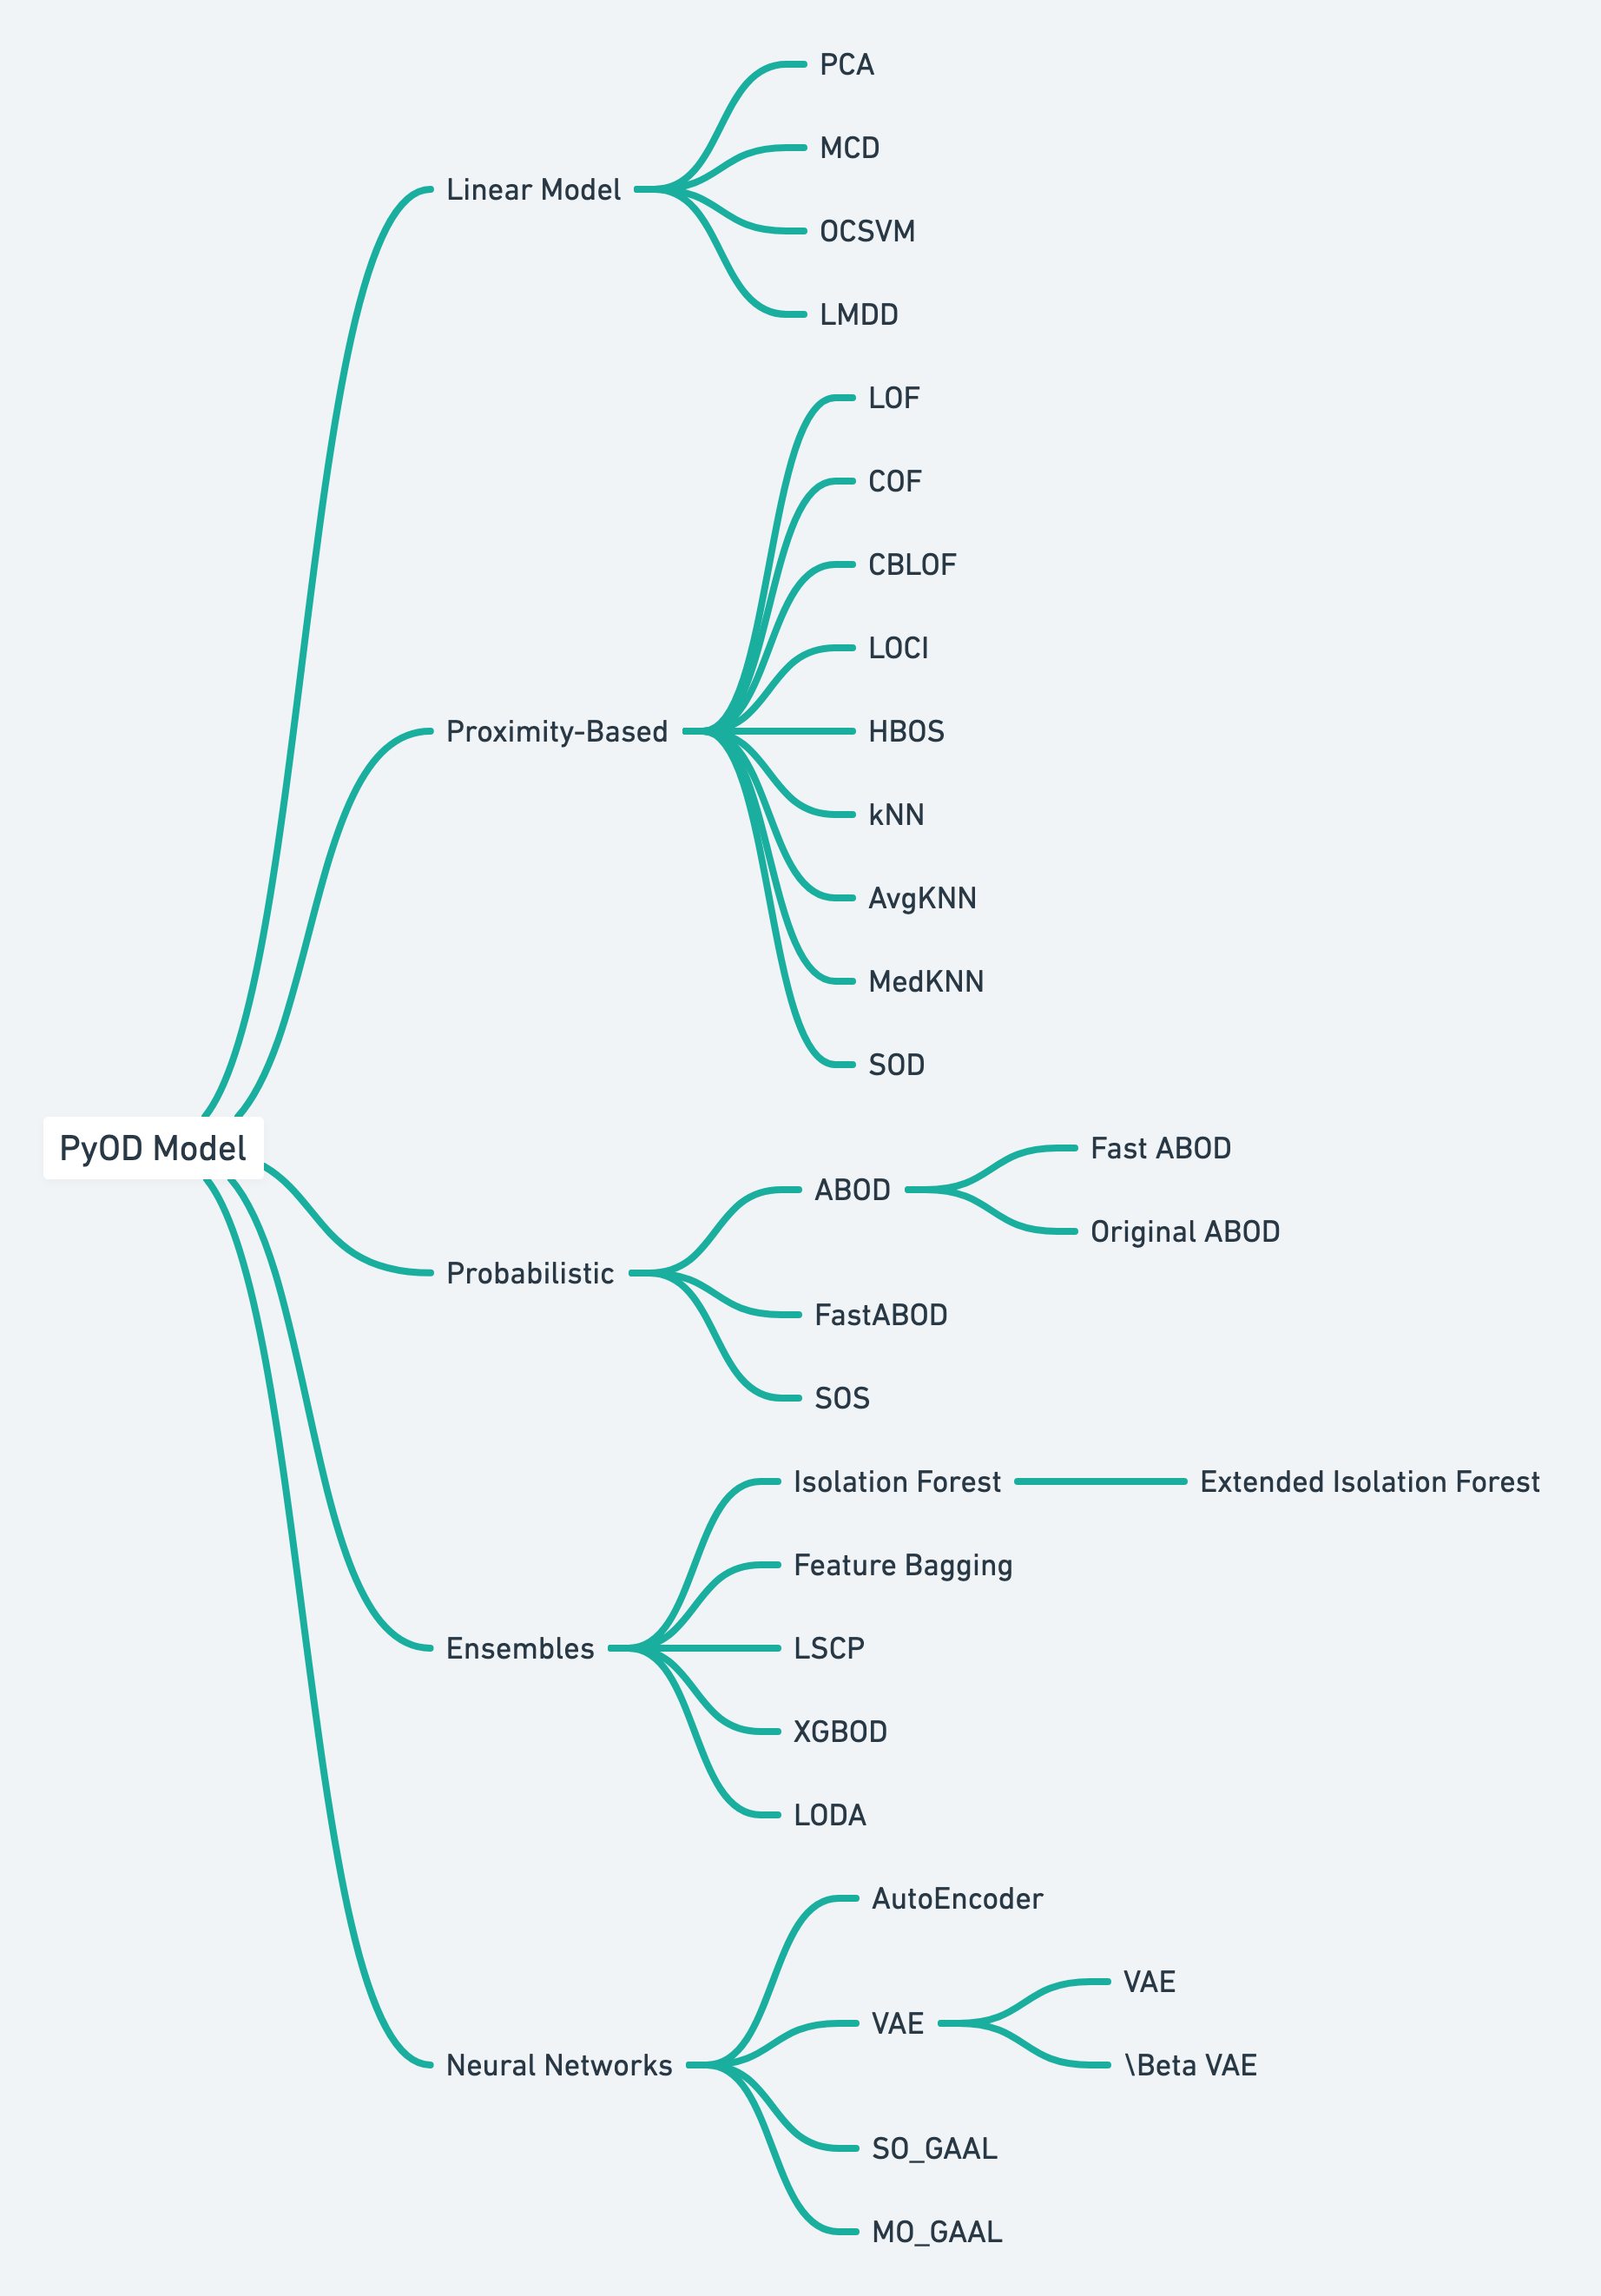

## 常用 PyOD Untility Functions 总结

### 1.pyod.utils.data.module
- `pyod.utils.data.evaluate_print(clf_name, y, y_pred)`
  - 主要作用：输出评价指标，默认指标包括ROC和Precision和Rank @n
  - 值得注意的是：异常检测问题和分类问题有高度的相似性，所以很多二分类中常用到的指标我们也可以用到异常检测领域。
  - Precision - 预测准确率，这个指标并不难理解
  - ROC - 二分类中涉及到许多分类标准，比如P阳性，N阴性，真阳性TP，真阴性TN，伪阳性FP，伪阴性FN等等。有的时候我们并不能仅仅去观察其中的一个指标，我们希望有效地观察所有和上述指标相关的指标作为我们最后的评判标准。例如：真阳性率$$TPR = \frac{TP}{TP+FN}$$，伪阳性率$$FPR = \frac{FP}{FP+TN}$$。而ROC空间，则将FPR定义为X轴，TPR定义为Y轴。我们可以在ROC空间中描绘一条对角线，从(0,0)点到(1,1)点。在这条线上的点我们认为它是一个比较良好的分类结果（好过随机分类50%的准确率），在这条线以下的点代表了差的分类结果。因此，如果我们ROC曲线上的点大多数位于该对角线上的左上角，我们就认为这个分类结果是较好的。
  - Rank@N 该指标最初是针对信息检索领域的，一般来说，搜索结果的前几项比较重要，故有此指标。在二分类中代表着结果中最靠前（置信度最高）的n个结果有正确结果的概率。其中rank 1代表着第一次命中，rank k代表第k次以内命中。

- `pyod.utils.data.generate_data(n_train=1000, n_test=500, n_features=2, contamination=0.1, train_only=False, offset=10, behaviour='old', random_state=None)` 
  - 主要作用：生成标记了异常的数据
  - **如何生成异常数据：**为了了解`generate_data()`函数如何生成异常数据，我去翻看了该函数的源代码文件，在https://github.com/yzhao062/pyod/blob/master/pyod/utils/data.py中。
  - 可以看到`inliers = coef * random_state.randn(n_inliers, n_features) + offset`这行代码，可以推测，这里人为生成的异常数据是在原始数据的基础上经过了一定的偏置 + offset运算得到的。方法很简单但是也非常有效

### 2.pyod.utils.example.module
- 跑样例的时候会用到的一些库，实际情况下我们应该会自己手动实现对应的可视化过程。

### 3.pyod.utils.stat_models module
统计模型的集合
- `pyod.utils.stat_models.pairwise_distances_no_broadcast(X, Y)`
计算两个矩阵的逐行欧式距离。 与成对计算不同，此功能不会广播。
- `pyod.utils.stat_models.pearsonr_mat(mat, w=None)`
逐行计算Pearson矩阵
- `pyod.utils.stat_models.wpearsonr(x, y, w=None)`
计算两个样本的加权Pearson相关性

### 4.pyod.utils.utility module
其他实用函数，主要用来支撑用户经常使用的功能。这个文件夹里的功能一般并不会被用户直接所使用。

## 实践
事实上因为PyOD和Sklearn高度相似的API，所以上手PyOD和上手Sklearn一样轻松。
使用PyOD进行异常检测可以分为如下几个步骤
1. train()训练模型：值得注意的是，在Anomaly Detection中，大部分模型都是无监督模型，所以很多时候我们并不需要一个标签数据，我们只需要一个X_train即可训练我们的模型
2. fit()预测模型：根据训练得到的模型针对测试集进行训练
3. 输出Evaluation Result => 常见的有 ROC, Precision Rank@N

### 使用PyOD中的AutoEncoder进行Anomaly Detection

In [4]:
from pyod.models.auto_encoder import AutoEncoder # 导入模型
from pyod.utils.data import generate_data # 人工生成数据
from pyod.utils.data import evaluate_print # 评测结果

In [5]:
# 参数设置 => 生成数据
contamination = 0.1
n_train = 20000
n_test = 2000
n_features = 300

# 生成样本数据
X_train, y_train, X_test, y_test = generate_data(
    n_train = n_train,
    n_test = n_test,
    n_features = n_features,
    contamination = contamination
)

/usr/local/lib/python3.6/dist-packages/pyod/utils/data.py:189: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.8.0. Please use behaviour="new", which makes the returned datasets in the order of X_train, X_test, y_train, y_test.
  FutureWarning)


In [6]:
# 训练 AutoEncoder Detector
clf_name = 'AutoEncoder'
clf = AutoEncoder(epochs = 30, contamination = contamination)
clf.fit(X_train)

# 获取训练数据的预测标签和离群值
y_train_pred = clf.labels_ # 0 inliers, 1 outliers
y_train_scores = clf.decision_scores_

# 获取测试数据的预测
y_test_pred = clf.predict(X_test) # outlier labels 0 or 1
y_test_scores = clf.decision_function(X_test) # outlier scores

# 评估并打印结果
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               90300     
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                19264     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2

### 作为对比，我们用Keras同样生成了一个AutoEncoder

In [7]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

In [14]:
model = keras.models.Sequential()
model.add(keras.Input(shape = (300, )))
model.add(keras.layers.Dense(64, activation = 'relu'))
model.add(keras.layers.Dense(32, activation = 'relu'))
model.add(keras.layers.Dense(32, activation = 'relu'))
model.add(keras.layers.Dense(64, activation = 'relu'))
model.add(keras.layers.Dense(300))
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.001), loss = "mse")
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 64)                19264     
_________________________________________________________________
dense_18 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_19 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_20 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_21 (Dense)             (None, 300)               19500     
Total params: 44,012
Trainable params: 44,012
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(
    X_train,
    X_train,
    epochs = 30,
    batch_size = 128,
    validation_split = 0.1,
    callbacks = [
      keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 5, mode = "min")           
    ],
)

Epoch 1/30
141/141 [==============================] - 1s 6ms/step - loss: 7.6353 - val_loss: 9.3454
Epoch 2/30
141/141 [==============================] - 1s 4ms/step - loss: 0.1662 - val_loss: 9.3036
Epoch 3/30
141/141 [==============================] - 1s 4ms/step - loss: 0.1659 - val_loss: 9.2550
Epoch 4/30
141/141 [==============================] - 0s 3ms/step - loss: 0.1656 - val_loss: 9.2104
Epoch 5/30
141/141 [==============================] - 0s 3ms/step - loss: 0.1650 - val_loss: 9.1683
Epoch 6/30
141/141 [==============================] - 0s 3ms/step - loss: 0.1645 - val_loss: 9.1322
Epoch 7/30
141/141 [==============================] - 1s 4ms/step - loss: 0.1640 - val_loss: 9.0957
Epoch 8/30
141/141 [==============================] - 1s 4ms/step - loss: 0.1641 - val_loss: 9.0682
Epoch 9/30
141/141 [==============================] - 1s 4ms/step - loss: 0.1635 - val_loss: 9.0433
Epoch 10/30
141/141 [==============================] - 1s 4ms/step - loss: 0.1634 - val_loss: 9.0219

In [22]:
x_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(x_train_pred - X_train), axis = 1)

In [23]:
threshold = np.max(train_mae_loss)
print(threshold)

2.9620641600390347


In [29]:
x_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(x_test_pred - X_test), axis = 1)
test_mae_loss = test_mae_loss.reshape((-1))
print(test_mae_loss)
anomalies = test_mae_loss > threshold

[0.31162943 0.32111187 0.32140835 ... 2.50376068 2.47326573 2.64893552]


In [33]:
print("True: ", np.sum(anomalies != 0))
print("False: ", np.sum(anomalies == 0))

True:  0
False:  2000


### 总结
1. PyOD在其易用性和效率上都好于自己使用Keras/Tensorflow/PyTorch自建神经网络
2. 如果针对小型demo进行异常检测，可以尝试使用PyOD进行快速异常检测，如果需要因地制宜设计神经网络，则可以考虑使用具体深度学习框架来构建神经网络